In [1103]:
import pandas as pd
from utils import get_engine
from dotenv import load_dotenv
from sqlalchemy import text
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [1104]:
load_dotenv()
engine = get_engine(echo_arg=True)

In [1105]:
from sklearn.metrics import r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
def get_best_estimator(pipe_list, params_list, X, y):
    estimators = []
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    for pipe, param in zip(pipe_list, params_list):
        grid = GridSearchCV(pipe, param, scoring='r2', n_jobs=-1, verbose=2)
        grid.fit(X_train, y_train)
        estimators.append(grid.best_estimator_)
    return estimators

def multi_regression(estimators, X, y):
    models, scores = ([], [])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    for estimator in estimators:
        model = MultiOutputRegressor(estimator, n_jobs=-1).fit(X_train, y_train)
        models.append(model)
        scores.append(model.score(X_test, y_test))
    return models, scores
        

In [1106]:
def plot_results(X, y, estimator, result):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
    y_pred = estimator.predict(X_test)
    print(result)
    plt.scatter(y_pred, y_test, color='blue')
    plt.title('result')
    plt.show()

In [1107]:
with engine.begin() as conn:
    query = text("""SELECT * FROM "CO2_selected_colums_for_lm_no_outlier_prepared_6_colums"; """)
    df = pd.read_sql(query, conn)

2023-06-17 20:25:03,128 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2023-06-17 20:25:03,130 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-06-17 20:25:03,175 INFO sqlalchemy.engine.Engine select current_schema()
2023-06-17 20:25:03,177 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-06-17 20:25:03,220 INFO sqlalchemy.engine.Engine show standard_conforming_strings
2023-06-17 20:25:03,222 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-06-17 20:25:03,265 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-06-17 20:25:03,276 INFO sqlalchemy.engine.Engine SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catalog.pg_class.relnamespace 
WHERE pg_catalog.pg_class.relname = %(table_name)s AND pg_catalog.pg_class.relkind = ANY (ARRAY[%(param_1)s, %(param_2)s, %(param_3)s, %(param_4)s, %(param_5)s]) AND pg_catalog.pg_table_is_visible(pg_catalog.pg_class.oid) AND pg_catalog.pg_namespace.nspname != %(nspname

In [1108]:
df.columns

Index(['YearBuilt', 'Have_Stream_Energy', 'Have_Electricity_Energy',
       'Have_NaturalGas_Energy', 'PrimaryPropertyType', 'NumberofBuildings',
       'LargestPropertyUseTypeGFA', 'TotalGHGEmissions', 'SiteEnergyUse_kBtu_',
       'LargestPropertyUseTypeGFA_log', 'TotalGHGEmissions_log',
       'SiteEnergyUse_kBtu_log'],
      dtype='object')

In [1109]:
y_multi = df[['TotalGHGEmissions_log', 'SiteEnergyUse_kBtu_log']]
y1, y2 = df['TotalGHGEmissions_log'], df['SiteEnergyUse_kBtu_log']

In [1110]:
X_cols = ['Have_Stream_Energy','Have_NaturalGas_Energy', 'PrimaryPropertyType', 
          'NumberofBuildings','LargestPropertyUseTypeGFA_log']

In [1111]:
X = df[X_cols]

In [1112]:
bool_cols = ['Have_Stream_Energy', 'Have_NaturalGas_Energy']
X[bool_cols] = X[bool_cols].apply(lambda x: x.apply(lambda x: 1 if x==True else 0))
X

/tmp/ipykernel_239762/1658224824.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[bool_cols] = X[bool_cols].apply(lambda x: x.apply(lambda x: 1 if x==True else 0))


,Have_Stream_Energy,Have_NaturalGas_Energy,PrimaryPropertyType,NumberofBuildings,LargestPropertyUseTypeGFA_log
0,1,1,Hotel,1,4.946619
1,0,1,Hotel,1,4.923658
2,1,1,Hotel,1,5.878805
3,1,1,Hotel,1,4.787602
4,0,1,Hotel,1,5.091474
...,...,...,...,...,...
3309,0,1,Office,1,4.089693
3310,0,1,Other,1,4.204120
3311,0,1,Other,1,3.879841
3312,0,1,Mixed Use Property,1,3.819610


In [1113]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor

In [1114]:
X_cat = X.select_dtypes(include=[object])
X_num = X.select_dtypes(exclude=[object])
gb = HistGradientBoostingRegressor()
xgb = XGBRegressor(objective='reg:squarederror')
ridge = Ridge()
rfr = RandomForestRegressor()

preparation = ColumnTransformer(transformers=[
    ('tf_cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), X_cat.columns),
    ('tf_num', RobustScaler(), X_num.columns)
])
pipe_gb = Pipeline(steps=[
    ('preparation', preparation),
    ('model', gb)
])

pipe_xgb = Pipeline(steps=[
    ('preparation', preparation),
    ('model', xgb)
])

pipe_ridge = Pipeline(steps=[
    ('preparation', preparation),
    ('model', ridge)
])

pipe_rfr = Pipeline(steps=[
    ('preparation', preparation),
    ('model', rfr)
])

In [1115]:
params_gbc = {'model__max_iter': [300, 400, 500]}
params_xbc = {'model__max_depth': [8, 9, 10]}
params_ridge = {'model__solver': ['auto', 'svd']}
params_rfr = {'model__n_estimators': [90, 100, 120]}

In [1116]:
pipe_list = [pipe_gb, pipe_ridge, pipe_xgb, pipe_rfr]
params_list = [params_gbc, params_ridge, params_xbc, params_rfr]

In [1117]:

estimators_1 = get_best_estimator(pipe_list, params_list, X, y1)
estimators_2 = get_best_estimator(pipe_list, params_list, X, y2)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[CV] END ................................model__max_iter=300; total time=   8.7s
[CV] END ................................model__max_iter=300; total time=  10.2s
[CV] END ................................model__max_iter=300; total time=  12.9s
[CV] END ................................model__max_iter=300; total time=  12.7s
[CV] END ................................model__max_iter=300; total time=  10.5s
[CV] END ................................model__max_iter=400; total time=  12.7s
[CV] END ................................model__max_iter=400; total time=  11.9s
[CV] END ................................model__max_iter=400; total time=  16.3s
[CV] END ................................model__max_iter=400; total time=  14.3s
[CV] END ................................model__max_iter=400; total time=  14.9s
[CV] END ................................model__max_iter=500; total time=  13.5s
[CV] END ................................model__max_iter=500; total time=  16.2s
[CV] END ...................

In [1118]:
estimators = estimators_1 + estimators_2

In [1119]:
models, scores = multi_regression(estimators, X, y_multi)

In [1120]:
for score in scores:
    print(score)

0.7792869058993986
0.7947584000953394
0.7487448504352943
0.7457324229115413
0.7792869058993986
0.7947584000953394
0.7487448504352943
0.7456199087580188


0.7792869058993986


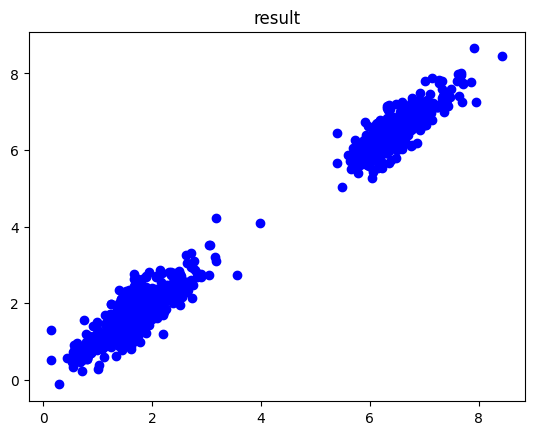

0.7947584000953394


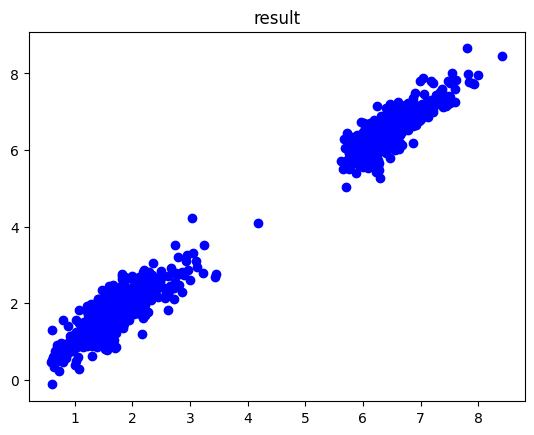

0.7487448504352943


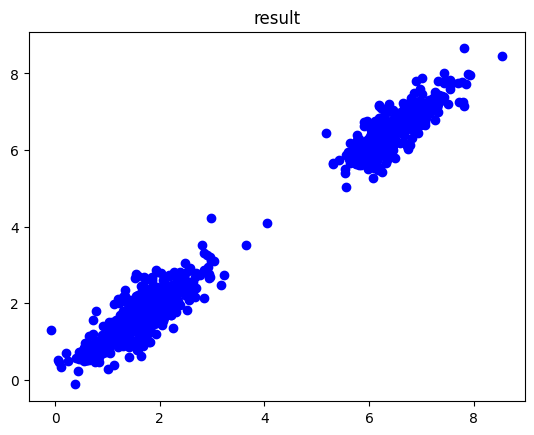

0.7457324229115413


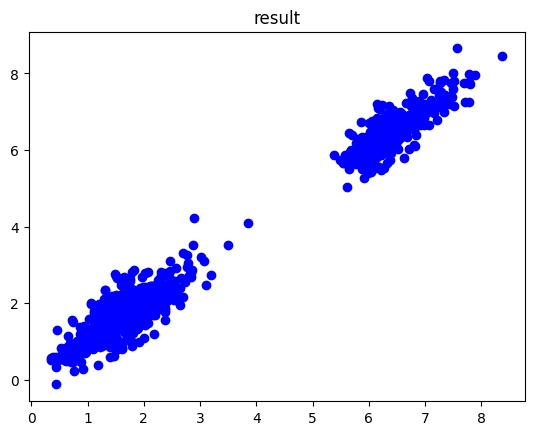

0.7792869058993986


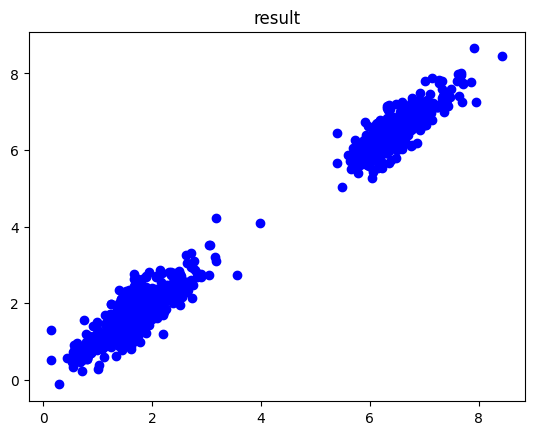

0.7947584000953394


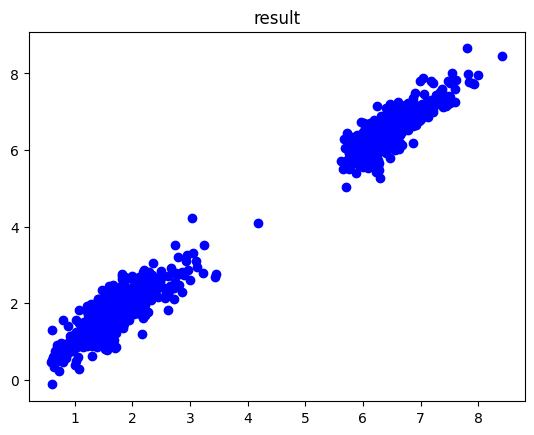

0.7487448504352943


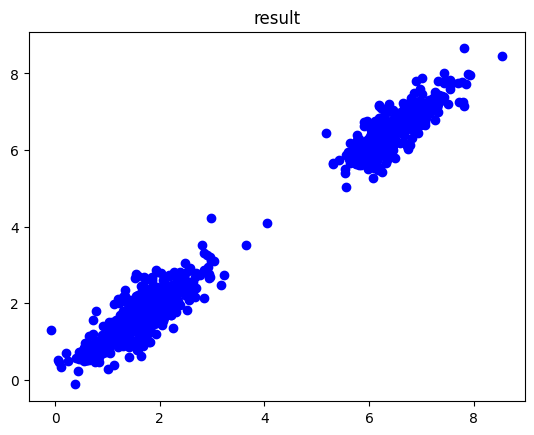

0.7456199087580188


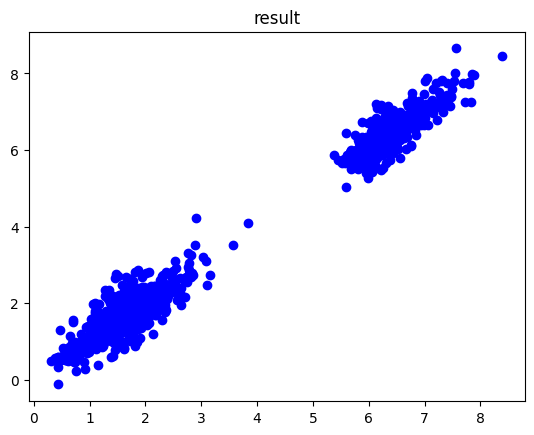

In [1121]:
for estimator, score in zip(models, scores):
    plot_results(X, y_multi, estimator, score)

In [1122]:
import joblib
joblib.dump(models[0], 'model.pkl')

['model.pkl']